<a href="https://colab.research.google.com/github/Zerowl7/tensorflow/blob/main/The_Keras_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создаем слои

In [75]:
# Load layers
from keras.layers import Input, Dense

# Input layer
input_tensor = Input(shape=(1,))

# Коннектим за один шаг
# Note that we did this in 2 steps in the previous exercise, but are doing it in one step now
output_tensor = Dense(1)(input_tensor)

Выходной слой позволяет вашей модели делать прогнозы.

# Построение модели

In [76]:
# Input/dense/output layers
from keras.layers import Input, Dense
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)

# Build the model
from keras.models import Model
model = Model(input_tensor, output_tensor)

# Компилируем модель

In [77]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Визуализация модели

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


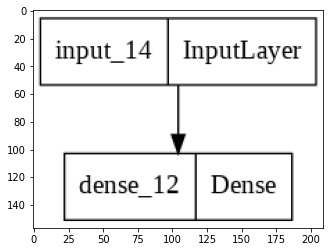

In [78]:
# Импортируем графики из matplotlib
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Summarize the model
model.summary()

# # График подгружается в png
plot_model(model, to_file='model.png')

# # Выводим изображение
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

Получаем 2 Тренированных слоя

# Фитим модель с баскетбольными играми

In [79]:
import pandas as pd

games_tourney_train = pd.read_csv('games_tourney.csv')
games_tourney_train.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [80]:
games_tourney_train.shape

(4234, 9)

имеет 4234 строчек

# Разделяем на подвыборки

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(games_tourney_train['seed_diff'], games_tourney_train['score_diff'])

In [82]:
# Фитим новую модель
model.fit(X_train, y_train,
          epochs=1,
          batch_size=128,
          validation_split=.10,
          verbose=True)

23/23 [==============================] - 0s 7ms/step - loss: 14.7130 - val_loss: 15.6596


# Оцениваем модель на тестовом наборе

In [83]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 1ms/step - loss: 14.9824


14.982434272766113

# Две входные сети с использованием категориальных вложений Shared Layers, and Merge Layers

# Определить поиск команды

In [84]:
games_season = pd.read_csv('games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [85]:
# Imports
from keras.layers import Embedding
from numpy import unique

# уникальный номер команды
n_teams = unique(games_season['team_1']).shape[0]

# Создаем embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

Embedding очень похож на словарь, но модель запоминает значения для каждого ключа.

# Определить модель команды

In [86]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Создаем Входной Слой
teamid_in = Input(shape=(1,))

# Поиск входных данных в embedding layer
strength_lookup = team_lookup(teamid_in)

# Сгладить вывод
strength_lookup_flat = Flatten()(strength_lookup)

# Объединение операций в единую повторно используемую модель
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

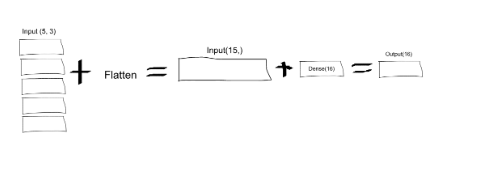

# Определение двух входов


In [87]:
# загружаем вход layer from keras.layers
from keras.layers import Input

# Input layer for team 1
team_in_1 = Input((1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input((1,), name='Team-2-In')

Эти два входа будут использоваться позже для общего слоя.

# Поиск обоих входов в одной и той же модели

In [88]:
# Ищем team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Ищем  team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Теперь модель знает, насколько сильна каждая команда.

# Выходной слой с использованием общего слоя

In [89]:
# Импортируем слой Subtract из keras
from keras.layers import Subtract

# Создаем Substract, со слоями
score_diff = Subtract()([team_1_strength, team_2_strength])

Substract принимает в качестве входных данных список тензоров размера 2 одинаковой формы и возвращает один тензор

Эта установка вычитает рейтинг силы команды, чтобы определить победителя.

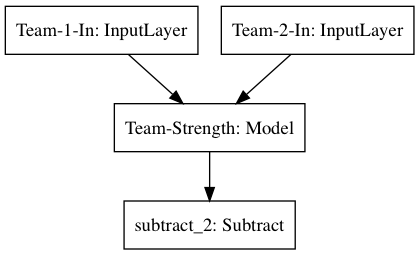

In [90]:
# Imports
from keras.layers import Subtract
from keras.models import Model

# Subtraction layer из предыдущего примера
score_diff = Subtract()([team_1_strength, team_2_strength])

# Создаем модель
model = Model([team_in_1, team_in_2], score_diff)

# Компилируем
model.compile(optimizer='adam', loss='mean_absolute_error')

In [91]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 subtract_3 (Subtract)          (None, 1)            0           ['Team-Strength-Model[0][0]

# Фитим данные регулярного сезона

In [92]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=.1,
          verbose=True)

138/138 [==============================] - 1s 3ms/step - loss: 12.1204 - val_loss: 11.8385


Наша модель была обучена в рейтинге для каждой команды

# Оценивание модели на тестовых данных турнира

In [93]:
games_tourney = pd.read_csv('games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [94]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], games_tourney['score_diff'])

133/133 [==============================] - 0s 1ms/step - loss: 11.6821


11.682055473327637

# Несколько входов: 3 входа (и больше!)

Создаем входной слой для home vs. away

Мы знаем, что в баскетболе есть хорошо задокументированное преимущество домашней команды, поэтому добавим в свою модель новые входные данные, чтобы зафиксировать этот эффект

In [95]:
from keras.layers.merge import Concatenate

In [96]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

Сейчас имеем 3 входных слоя

# Строим Модель

In [97]:
# Import the model class
from keras.models import Model

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [98]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 Home-In (InputLayer)           [(None, 1)]          0           []                         

# Собирем модель и оценим

In [99]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.1,
          batch_size=2048)

# Оценка the model on the games_tourney dataset
model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], games_tourney['score_diff'])

133/133 [==============================] - 0s 1ms/step - loss: 11.6886


11.688638687133789

Обучение сети — это поиск параметров, минимизирующих функцию потерь (или функцию стоимости).

Как видим, если больше входов меньше функция потерь

# Plotting


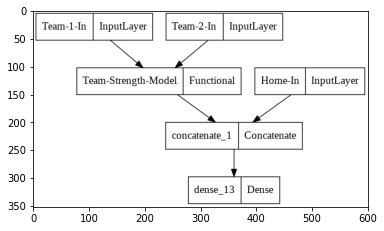

In [100]:
# Imports
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

# Добавим предсказания модели к данным турнира

In [101]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'],games_tourney['team_2'],games_tourney['home']])

In [102]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,0.087890
1,1985,5929,73,0,4,6,61,55,1,0.077235
2,1985,9884,73,0,5,-4,59,63,0,0.105535
3,1985,73,288,0,3,9,50,41,1,0.156003
4,1985,3920,410,0,1,-9,54,63,0,0.144482


In [103]:
games_tourney.score_diff.unique()

array([ -9,   6,  -4,   9,   3,  -2,  -1,   2,   5,   1, -13,   4,  -6,
       -25, -12, -18, -17,  16,  -8,  -7, -16,   8, -19,  -3,  11, -11,
        25, -24,  12,  23,  -5,   7,  19, -23,  13,  17,  24,  18,  10,
        14, -10,  32,  49,  20, -21, -28, -15, -22, -20, -14,  15, -32,
        21,  28, -49,  22,  34, -34, -31,  31, -40, -29,  40,  26,  27,
       -26, -27,  29,  43, -37, -43,  37,  30, -35,  35, -30, -41,  41,
       -38,  38,  39,  33, -39, -33, -44, -45,  45,  44,  36, -46,  46,
       -36, -58,  58, -42,  42, -47,  47,  56, -56])

Теперь попробуем построить с предиктами

# Создать входной слой с несколькими столбцами

In [104]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit

In [105]:
games_tourney_train = games_tourney.query('season < 2010')

In [106]:
games_tourney_train.shape

(3168, 10)

In [107]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

99/99 [==============================] - 0s 1ms/step - loss: 15.0064


Evaluate

In [108]:
games_tourney_test = games_tourney.query('season >= 2010')

In [109]:
games_tourney_test.shape

(1066, 10)

In [110]:
# Evaluate the model on the games_tourney_test dataset
model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']], 
               games_tourney_test['score_diff'])

34/34 [==============================] - 0s 1ms/step - loss: 13.8310


13.83099365234375

О, еще меньше

# Несколько выходов

«множественная целевая регрессия»: одна модель делает более одного прогноза.

In [111]:
# Define the input
input_tensor = Input((2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit

In [112]:
# Fit the model
model.fit(games_tourney_train[['seed_diff', 'pred']],
  		  games_tourney_train[['score_1', 'score_2']],
  		  verbose=False,
  		  epochs=1000,
  		  batch_size=64)

In [113]:
import numpy as np

In [114]:
np.mean(model.history.history['loss'])

43.54045794868469

# Рассмотрим модель

Входной слой будет иметь 4 веса: 2 для каждого входа, умноженное на 2 для каждого выхода.

Выходной слой будет иметь 2 веса, по одному для каждого выхода.

In [115]:
# Веса
print(model.get_weights())

# Тренировочные данные средние значения
print(games_tourney_train.mean())

[array([[ 0.5685208 , -0.57885724],
       [49.781696  , 50.865234  ]], dtype=float32), array([49.800053, 49.803005], dtype=float32)]
season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred             0.135839
dtype: float64


оба выходных веса составляют около ~ 48? Это связано с тем, что в среднем команда на турнире набирает около 48 очков.

# Оценка

In [116]:
# Evaluate the model on the tournament test data
model.evaluate(games_tourney_test[['seed_diff', 'pred']],games_tourney_test[['score_1', 'score_2']])

34/34 [==============================] - 0s 1ms/step - loss: 13.1982


13.1981840133667

# Classification and regression in one model


In [117]:
# Create an input layer with 2 columns
input_tensor = Input((2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

# fit

In [118]:
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam # - Works

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(lr=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 560ms/step - loss: 10.0738 - dense_16_loss: 9.2262 - dense_17_loss: 0.8476
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 10.0626 - dense_16_loss: 9.2194 - dense_17_loss: 0.8433
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 10.0515 - dense_16_loss: 9.2129 - dense_17_loss: 0.8387
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 10.0403 - dense_16_loss: 9.2065 - dense_17_loss: 0.8339
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 10.0291 - dense_16_loss: 9.2003 - dense_17_loss: 0.8288
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 10.0180 - dense_16_loss: 9.1944 - dense_17_loss: 0.8237
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 10.0071 - dense_16_loss: 9.1891 - dense_17_loss: 0.8181
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 9.9964 - dense_16_loss: 9.1844 - dense_17_loss: 0.812

Adam - Согласно Kingma et al., 2014 , этот метод « эффективен в вычислительном отношении, требует мало памяти, инвариантен к диагональному масштабированию градиентов и хорошо подходит для задач, которые являются большими с точки зрения данных/параметров ».

# Inspect

In [119]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[ 1.111932  ],
       [-0.95994455]], dtype=float32), array([[0.49986944]], dtype=float32)]
season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred             0.135839
dtype: float64


In [120]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


Таким образом, сигмоид (1 * 0,14) равен 0,53, что представляет довольно близкую игру, а сигмоид (10 * 0,14) равен 0,80, что представляет довольно вероятный выигрыш. Другими словами, если модель предсказывает выигрыш в 1 очко, она менее уверена в выигрыше, чем если бы она предсказывала 10 очков. Кто сказал, что нейронные сети — это черные ящики

# Evaluate

In [121]:
# Evaluate the model on new data
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]])

34/34 [==============================] - 0s 1ms/step - loss: 9.9951 - dense_16_loss: 9.0833 - dense_17_loss: 0.9118


[9.995055198669434, 9.083268165588379, 0.9117881655693054]

Keras вернет 3 числа:

первое число будет суммой обеих функций потерь,

следующие 2 числа будут функциями потерь, которые использовали при определении модели.

модель играет роль регрессора и хорошего классификатора